In [22]:
# Basic import
import os
import sys
import json
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Helper function
def writeProgress(msg, count, total):
    sys.stdout.write(msg + "{:.2%}\r".format(count/total))
    sys.stdout.flush()
    
def newPath(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def read_json(src_path):
    with open(src_path, 'r') as json_file:
        data = json.load(json_file)
    return data

def write_json(data,dst_path):
    with open(dst_path, 'w') as outfile:
        json.dump(data, outfile)

In [3]:
# 讀取固定的類別順序
genres = read_json('../orderdListGenres.json')
print(len(genres), genres)

20 ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']


In [4]:
# 讀取電影所屬的分類
genresMat = read_json('../genresMat.json')
len(genresMat)

97

# Makedir SplitTrailers_crop/

In [5]:
PATH = './Trailers/'
TRAILER = './SplitTrailers_crop/'
newPath(TRAILER)

In [6]:
from __future__ import print_function
import scenedetect
from scenedetect.video_manager import VideoManager
from scenedetect.scene_manager import SceneManager
from scenedetect.frame_timecode import FrameTimecode
from scenedetect.stats_manager import StatsManager
from scenedetect.detectors import ContentDetector
import cv2     # for capturing videos

In [12]:
def splitScene(dic, horizontal = True):
    for key, v in dic.items():

        video = PATH + key + '.mp4'
        border = v
        print(key, border)

        savePath = TRAILER + key
        newPath(savePath)

        cap = cv2.VideoCapture(video)
        w = int(cap.get(3))
        h = int(cap.get(4))
        fps = cap.get(5)
        duration = cap.get(7)
        print(w, 'x', h, 'FPS:', fps, duration)
        fourcc = cv2.VideoWriter_fourcc(*'XVID')

        # scenedetect
        video_manager = VideoManager([video])
        stats_manager = StatsManager()
        scene_manager = SceneManager(stats_manager)
        # Add ContentDetector algorithm (constructor takes detector options like threshold).
        scene_manager.add_detector(ContentDetector())
        base_timecode = video_manager.get_base_timecode()

        try:
            video_manager.set_duration()

            # Set downscale factor to improve processing speed (no args means default).
            video_manager.set_downscale_factor()

            # Start video_manager.
            video_manager.start()

            # Perform scene detection on video_manager.
            scene_manager.detect_scenes(frame_source=video_manager)

            # Obtain list of detected scenes.
            scene_list = scene_manager.get_scene_list(base_timecode)
            # Like FrameTimecodes, each scene in the scene_list can be sorted if the
            # list of scenes becomes unsorted.

    #         print('List of scenes obtained:')
            length = len(scene_list)
            print('Scene count:', length)
            for i, scene in enumerate(scene_list):

                scenePath = savePath + '/' + 'scene_' + str(i+1) +'/'
                newPath(scenePath)

                framePath = scenePath + 'frames/'
                newPath(framePath)
                filename = scenePath + 'clip.avi'
    #             print(filename)

                out = cv2.VideoWriter(filename, fourcc, fps, (w, h))

                start = scene[0].get_frames()
                end = scene[1].get_frames()

                cap.set(1,start)

                while(cap.isOpened()):

                    ret, frame = cap.read()
                    if horizontal:
                        frame = frame[border: h - border, :] # horizontal
                    else:
                        frame = frame[:, border: w - border] # vertical

                    current = int(cap.get(1))

                    if (ret == True):
                        out.write(frame)
                        cv2.imwrite(framePath + str(current) + '.jpg', frame)

                        if current == end:
                            break
                    else:
                        break

                    writeProgress('Progerss:',current, duration)
        finally:
            video_manager.release()
            cap.release()
            out.release()

## Get horizontal and vertical dict respectively

In [8]:
dic_h = read_json('./json/crop_dict4Trailers.json')
print(len(dic_h))
del dic_h['highlifemovie']
print(len(dic_h))

dic_v = read_json('./json/crop_dict4Trailers_vertical.json')
print(dic_v)

97
96
{'highlifemovie': 28}


### For horizontal crop

In [9]:
splitScene(dic_h)

yesterdaymovie 93
1280 x 720 FPS: 23.976023976023978 4560.0
Scene count: 143
toystory 09.98%
1280 x 536 FPS: 23.976023976023978 3539.0
Scene count: 95
arcticmovie 92%
1280 x 720 FPS: 23.976023976023978 4067.0
Scene count: 56
secretlifeofpets 17
1280 x 720 FPS: 29.97002997002997 450.0
Scene count: 8
annamovie 9278%
1280 x 720 FPS: 23.976023976023978 3374.0
Scene count: 89
overcomermovie 0
1280 x 536 FPS: 23.976023976023978 3389.0
Scene count: 107
usmovie 939.97%
1280 x 720 FPS: 25.0 4215.0
Scene count: 98
lionking 09.98%
1280 x 690 FPS: 23.976023976023978 2606.0
Scene count: 52
captainmarvelofficial 92
1280 x 720 FPS: 23.976023976023978 2796.0
Scene count: 58
uglydolls 1296%
1280 x 720 FPS: 23.976023976023978 2922.0
Scene count: 57
littlewoodsfilm 92
1280 x 720 FPS: 23.976023976023978 3480.0
Scene count: 72
lastblackmansf 0
1200 x 720 FPS: 23.976023976023978 3208.0
Scene count: 62
annabellemovie 90
1280 x 720 FPS: 23.976023976023978 3456.0
Scene count: 66
scarystoriesmovie 91
1280 x 720

### For vertical crop

In [13]:
splitScene(dic_v, horizontal = False)

highlifemovie 28
1280 x 720 FPS: 23.976023976023978 3433.0
Scene count: 79


# Check crop results

In [17]:
import random

In [15]:
originPath = './SplitTrailers/'
cropPath = './SplitTrailers_crop/'

Running: 97 yesterdaymovie
3107.jpg


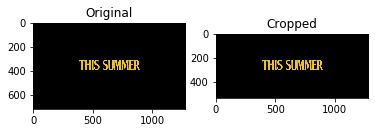

KeyboardInterrupt: 

In [31]:
countdown = len(os.listdir(originPath))
for movie in os.listdir(originPath):
    print('Running:', countdown, movie)
    sceneList = os.listdir(originPath + movie)
    nxt = True
    while nxt:
        scene = random.choice(sceneList)
        framePath = originPath + movie + '/' + scene + '/frames/'
        frameList = [int(name.split('.')[0]) for name in os.listdir(framePath)]
        frameList.sort()
    #     print(frameList)
        keyframe = str(frameList[len(frameList)//2]) + '.jpg'
        print(keyframe)

        ori_img = cv2.imread(originPath + movie + '/' + scene + '/frames/' + keyframe)[:,:,::-1]
        crop_img = cv2.imread(cropPath + movie + '/' + scene + '/frames/' + keyframe)[:,:,::-1]

        plt.subplot(121).set_title("Original"), plt.imshow(ori_img)
        plt.subplot(122).set_title("Cropped"), plt.imshow(crop_img)
        plt.show()
        
        usr_input = input()
        # "Enter" to next movie, otherwise random pick another image for check
        if usr_input == '': # move forwards
            nxt = False
            countdown -=1